# Experimentos:

In [10]:
!pip install requests

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df_spotify = pd.read_excel('Spotify.xlsx')

#Ajustamos columnas para contraarrestar error de formato en archivo xlsx
df_spotify['duration_ms'] = df_spotify['duration_ms']/10
df_spotify['popularity'] = df_spotify['popularity']/10
df_spotify['streams'] = df_spotify['streams']/10
df_spotify['af_danceability'] = df_spotify['af_danceability']/1000
df_spotify['af_energy'] = df_spotify['af_energy']/1000
df_spotify['af_key'] = df_spotify['af_key']/10
df_spotify['af_loudness'] = df_spotify['af_loudness']/1000
df_spotify['af_speechiness'] = df_spotify['af_speechiness']/1000
df_spotify['af_acousticness'] = df_spotify['af_acousticness']/1000
df_spotify['af_instrumentalness'] = df_spotify['af_instrumentalness']/1000
df_spotify['af_liveness'] = df_spotify['af_liveness']/1000
df_spotify['af_valence'] = df_spotify['af_valence']/1000
df_spotify['af_tempo'] = df_spotify['af_tempo']/1000
df_spotify['af_time_signature'] = df_spotify['af_time_signature']/10

## Pregunta 3:
- ¿Qué parámetros son más adecuados para predecir la popularidad de una canción?

In [11]:
import requests
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

def remove_numbers(text):
    text = re.sub(r"[0-9]", " ", text)
    return " ".join(text.split())

def remove_unprintable_(text):
    printable = set(string.printable + "ñáéíóúü" + "ÑÁÉÍÓÚÜ")
    text = "".join(filter(lambda x: x in printable, text))
    return text

def remove_punctuation(text):
    pattern = re.compile(r"[^\w\sáéíóúüñÁÉÍÓÚÜÑ]")
    t = pattern.sub(r" ", text)
    return re.sub(" +", " ", t)

def reduce_spam(text):
    text = re.sub(r"(\w+)(\s+\1){2,}", r"\1", text)
    text = re.sub(r"(\w+\s+\w+)(\s+\1){2,}", r"\1", text)
    return text

def remove_vowels_accents(text):
    return (
        text.replace("á", "a")
        .replace("é", "e")
        .replace("í", "i")
        .replace("ó", "o")
        .replace("ú", "u")
        .replace("ü", "u")
    )

def remove_stopwords(text, stopwords_list):
    return " ".join(
        [word for word in str(text).split() if word not in stopwords_list]
    )

url = "https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt"
r = requests.get(url)

stopwords_list = r.text.splitlines()

def preprocesar(text):
    text = text.lower()
    text = remove_numbers(text)
    text = remove_unprintable_(text)
    text = remove_punctuation(text)
    text = reduce_spam(text)
    text = remove_stopwords(text, stopwords_list)
    text = remove_vowels_accents(text)
    return text.strip()

Calculamos una medida para clasificar la popularidad por rangos

In [12]:
cuartiles = df_spotify['popularity'].quantile([0.25, 0.5, 0.75])

Clasificamos la popularidad en rangos

In [13]:
for index, row in df_spotify.iterrows():
    if row['popularity']>=cuartiles[0.75]:
        df_spotify['popularity'].iat[index] = 0
    elif row['popularity']>=cuartiles[0.50]:
        df_spotify['popularity'].iat[index] = 1
    elif row['popularity']>=cuartiles[0.25]:
        df_spotify['popularity'].iat[index] = 2
    else:
        df_spotify['popularity'].iat[index] = 3

In [14]:
df_P3 = df_spotify.copy()

### Intento 1: danzabilidad y streams

In [15]:
df_P3=df_P3.drop(columns=['af_key','duration_ms', 'af_energy','af_loudness', 
            'af_acousticness','af_speechiness', 'af_instrumentalness', 'af_liveness', 'af_valence','af_tempo','date','url','chart', 'track_id','available_markets','Año','Día','Column1','release_date','explicit','title','artist','trend','album','af_mode','rank','af_time_signature'])

Reemplazamos la columna de popularidad

In [16]:
from sklearn.preprocessing import StandardScaler
features = ['region','streams', 'af_danceability']

Preparamos el dataset para entrenar

In [17]:
X = df_P3[features]
y = df_P3['popularity']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=0, stratify=y_val_and_test)

Generamos un pipeline para:
- Transformar texto
- Estandarizar los datos
- Aplicar un clasificador (random forest)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np

# Define tus columnas
text_feature = 'region'
numeric_features = ['streams', 'af_danceability']

# Crear la pipeline completa
clf_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('text', Pipeline([
                ('vectorizer', CountVectorizer(min_df=1, preprocessor = preprocesar)),
                ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
            ]), text_feature),
            ('num', StandardScaler(), numeric_features)
        ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

Entrenamos

In [20]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocesar at 0x000002D3D1556A20>)),
                                                                  ('to_dense',
                                                                   FunctionTransformer(accept_sparse=True,
                                                                                       func=<function <lambda> at 0x000002D3D51CFC40>))]),
                                                  'region'),
                                                 ('num', StandardScaler(),
                                                  ['streams',
                                                   'af_danceability'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

predecimos 

In [21]:
y_pred = clf_pipeline.predict(X_test)

evaluamos la predicción

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
target_names = ['High', 'Low', 'Medium-High', 'Medium-Low']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        High       0.87      0.89      0.88     40543
         Low       0.87      0.87      0.87     36047
 Medium-High       0.85      0.84      0.85     36984
  Medium-Low       0.87      0.85      0.86     37784

    accuracy                           0.86    151358
   macro avg       0.86      0.86      0.86    151358
weighted avg       0.86      0.86      0.86    151358



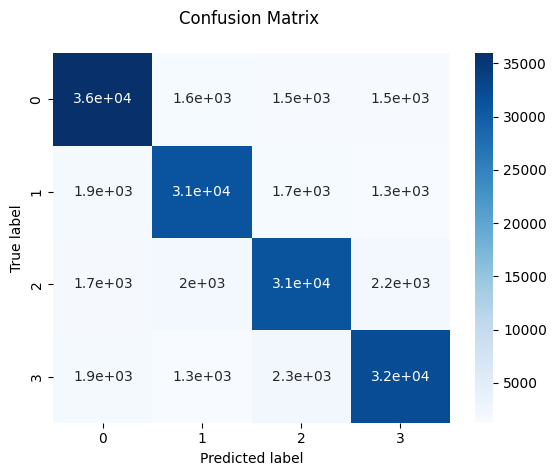

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred) # calcula valores de la matriz de confusión

fig, ax = plt.subplots()

ax = sns.heatmap(cm, annot=True, cmap="Blues") # transforma la matriz en un heatmap para su visualización

ax.set_title('Confusion Matrix \n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

In [24]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

cv_results = cross_validate(clf_pipeline, X, y, cv=10, scoring=scoring)
print('Promedio Precision:', np.mean(cv_results['test_precision_macro']))
print('Promedio Recall:   ', np.mean(cv_results['test_recall_macro']))
print('Promedio F1-score: ', np.mean(cv_results['test_f1_macro']))
print('Promedio Accucary: ', np.mean(cv_results['test_accuracy']))

Promedio Precision: 0.8297254067132542
Promedio Recall:    0.8292259002638372
Promedio F1-score:  0.8293004777349287
Promedio Accucary:  0.829870670432585


### Intento 2: duración y danzabilidad

In [25]:
df_P3_2 = df_spotify.copy()

In [26]:
df_P3_2=df_P3_2.drop(columns=['af_key','streams', 'af_energy','af_loudness', 
            'af_acousticness','af_speechiness', 'af_instrumentalness', 'af_liveness', 'af_valence','af_tempo','date','url','chart', 'track_id','available_markets','Año','Día','Column1','release_date','explicit','title','artist','trend','album','af_mode','rank','af_time_signature'])

Reemplazamos la columna de popularidad

In [27]:
from sklearn.preprocessing import StandardScaler
features = ['region','duration_ms', 'af_danceability']

Preparamos el dataset para entrenar

In [28]:
X = df_P3_2[features]
y = df_P3_2['popularity']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=0, stratify=y_val_and_test)

Generamos un pipeline para:
- Transformar texto
- Estandarizar los datos
- Aplicar un clasificador (random forest)

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np

# Define tus columnas
text_feature = 'region'
numeric_features = ['duration_ms', 'af_danceability']

# Crear la pipeline completa
clf_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('text', Pipeline([
                ('vectorizer', CountVectorizer(min_df=1, preprocessor = preprocesar)),
                ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
            ]), text_feature),
            ('num', StandardScaler(), numeric_features)
        ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

Entrenamos

In [31]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocesar at 0x000002D3D1556A20>)),
                                                                  ('to_dense',
                                                                   FunctionTransformer(accept_sparse=True,
                                                                                       func=<function <lambda> at 0x000002D3F0BBEDE0>))]),
                                                  'region'),
                                                 ('num', StandardScaler(),
                                                  ['duration_ms',
                                                   'af_danceability'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

predecimos 

In [32]:
y_pred = clf_pipeline.predict(X_test)

evaluamos la predicción

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
target_names = ['High', 'Low', 'Medium-High', 'Medium-Low']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        High       0.99      1.00      0.99     40543
         Low       0.99      0.99      0.99     36047
 Medium-High       0.99      0.98      0.98     36984
  Medium-Low       0.99      0.98      0.98     37784

    accuracy                           0.99    151358
   macro avg       0.99      0.99      0.99    151358
weighted avg       0.99      0.99      0.99    151358



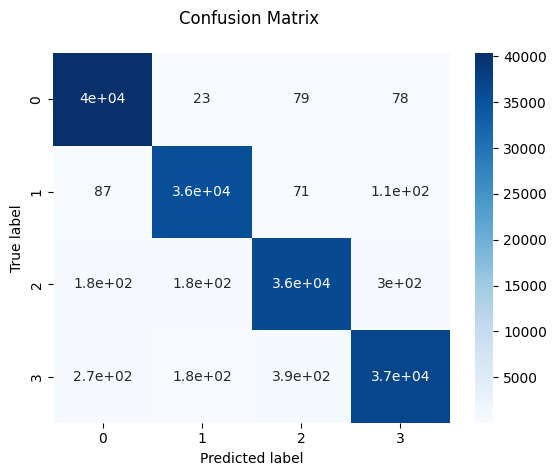

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred) # calcula valores de la matriz de confusión

fig, ax = plt.subplots()

ax = sns.heatmap(cm, annot=True, cmap="Blues") # transforma la matriz en un heatmap para su visualización

ax.set_title('Confusion Matrix \n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

In [35]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

cv_results = cross_validate(clf_pipeline, X, y, cv=10, scoring=scoring)
print('Promedio Precision:', np.mean(cv_results['test_precision_macro']))
print('Promedio Recall:   ', np.mean(cv_results['test_recall_macro']))
print('Promedio F1-score: ', np.mean(cv_results['test_f1_macro']))
print('Promedio Accucary: ', np.mean(cv_results['test_accuracy']))

Promedio Precision: 0.9771783867711068
Promedio Recall:    0.9770224100609747
Promedio F1-score:  0.9770584780732078
Promedio Accucary:  0.9772112382934445


### Intento 3: nota y danzabilidad

In [36]:
df_P3_2 = df_spotify.copy()

In [37]:
df_P3_2=df_P3_2.drop(columns=['duration_ms','streams', 'af_energy','af_loudness', 
            'af_acousticness','af_speechiness', 'af_instrumentalness', 'af_liveness', 'af_valence','af_tempo','date','url','chart', 'track_id','available_markets','Año','Día','Column1','release_date','explicit','title','artist','trend','album','af_mode','rank','af_time_signature'])

Reemplazamos la columna de popularidad

In [38]:
from sklearn.preprocessing import StandardScaler
features = ['region','af_key', 'af_danceability']

Preparamos el dataset para entrenar

In [39]:
X = df_P3_2[features]
y = df_P3_2['popularity']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=0, stratify=y_val_and_test)

Generamos un pipeline para:
- Transformar texto
- Estandarizar los datos
- Aplicar un clasificador (random forest)

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np

# Define tus columnas
text_feature = 'region'
numeric_features = ['af_key', 'af_danceability']

# Crear la pipeline completa
clf_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('text', Pipeline([
                ('vectorizer', CountVectorizer(min_df=1, preprocessor = preprocesar)),
                ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
            ]), text_feature),
            ('num', StandardScaler(), numeric_features)
        ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

Entrenamos

In [42]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocesar at 0x000002D3D1556A20>)),
                                                                  ('to_dense',
                                                                   FunctionTransformer(accept_sparse=True,
                                                                                       func=<function <lambda> at 0x000002D3F4291440>))]),
                                                  'region'),
                                                 ('num', StandardScaler(),
                                                  ['af_key',
                                                   'af_danceability'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

predecimos 

In [43]:
y_pred = clf_pipeline.predict(X_test)

evaluamos la predicción

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
target_names = ['High', 'Low', 'Medium-High', 'Medium-Low']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        High       0.98      0.99      0.98     40543
         Low       0.98      0.98      0.98     36047
 Medium-High       0.97      0.97      0.97     36984
  Medium-Low       0.98      0.96      0.97     37784

    accuracy                           0.98    151358
   macro avg       0.98      0.98      0.98    151358
weighted avg       0.98      0.98      0.98    151358



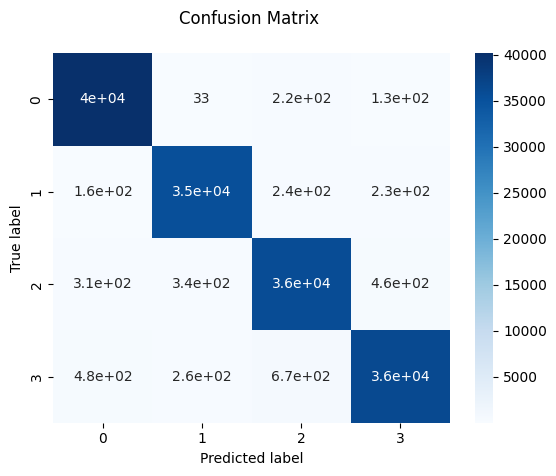

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred) # calcula valores de la matriz de confusión

fig, ax = plt.subplots()

ax = sns.heatmap(cm, annot=True, cmap="Blues") # transforma la matriz en un heatmap para su visualización

ax.set_title('Confusion Matrix \n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

In [46]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

cv_results = cross_validate(clf_pipeline, X, y, cv=10, scoring=scoring)
print('Promedio Precision:', np.mean(cv_results['test_precision_macro']))
print('Promedio Recall:   ', np.mean(cv_results['test_recall_macro']))
print('Promedio F1-score: ', np.mean(cv_results['test_f1_macro']))
print('Promedio Accucary: ', np.mean(cv_results['test_accuracy']))

Promedio Precision: 0.9646523303437249
Promedio Recall:    0.9643394119520803
Promedio F1-score:  0.9644194085647673
Promedio Accucary:  0.9646340617412419


### Intento 4: nota y loudness

In [47]:
df_P3_2 = df_spotify.copy()

In [48]:
df_P3_2=df_P3_2.drop(columns=['duration_ms','streams', 'af_energy','af_danceability', 
            'af_acousticness','af_speechiness', 'af_instrumentalness', 'af_liveness', 'af_valence','af_tempo','date','url','chart', 'track_id','available_markets','Año','Día','Column1','release_date','explicit','title','artist','trend','album','af_mode','rank','af_time_signature'])

Reemplazamos la columna de popularidad

In [49]:
from sklearn.preprocessing import StandardScaler
features = ['region','af_key', 'af_loudness']

Preparamos el dataset para entrenar

In [50]:
X = df_P3_2[features]
y = df_P3_2['popularity']

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=0, stratify=y_val_and_test)

Generamos un pipeline para:
- Transformar texto
- Estandarizar los datos
- Aplicar un clasificador (random forest)

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np

# Define tus columnas
text_feature = 'region'
numeric_features = ['af_key', 'af_loudness']

# Crear la pipeline completa
clf_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('text', Pipeline([
                ('vectorizer', CountVectorizer(min_df=1, preprocessor = preprocesar)),
                ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
            ]), text_feature),
            ('num', StandardScaler(), numeric_features)
        ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

Entrenamos

In [53]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocesar at 0x000002D3D1556A20>)),
                                                                  ('to_dense',
                                                                   FunctionTransformer(accept_sparse=True,
                                                                                       func=<function <lambda> at 0x000002D3F9B17F60>))]),
                                                  'region'),
                                                 ('num', StandardScaler(),
                                                  ['af_key', 'af_loudness'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

predecimos 

In [54]:
y_pred = clf_pipeline.predict(X_test)

evaluamos la predicción

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
target_names = ['High', 'Low', 'Medium-High', 'Medium-Low']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        High       0.99      0.99      0.99     40543
         Low       0.99      0.99      0.99     36047
 Medium-High       0.98      0.98      0.98     36984
  Medium-Low       0.98      0.97      0.98     37784

    accuracy                           0.98    151358
   macro avg       0.98      0.98      0.98    151358
weighted avg       0.98      0.98      0.98    151358



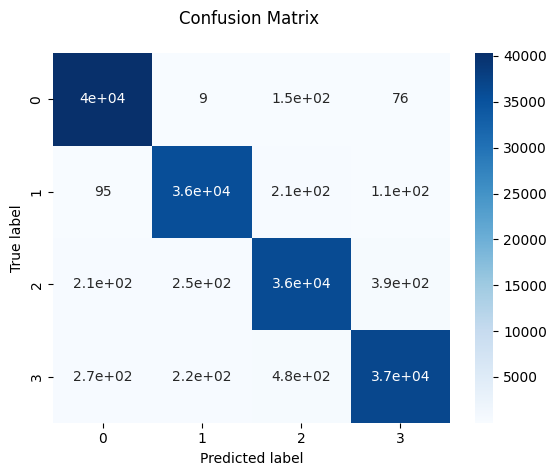

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred) # calcula valores de la matriz de confusión

fig, ax = plt.subplots()

ax = sns.heatmap(cm, annot=True, cmap="Blues") # transforma la matriz en un heatmap para su visualización

ax.set_title('Confusion Matrix \n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

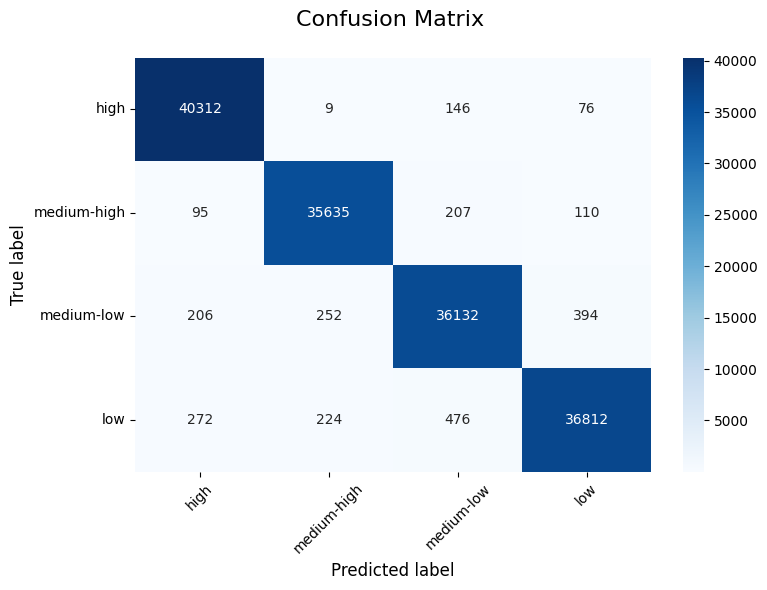

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear etiquetas personalizadas
labels = ['high', 'medium-high', 'medium-low', 'low']

# Configurar el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)

# Personalizar el título y los ejes
ax.set_title('Confusion Matrix \n', fontsize=16)
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()
plt.show()


In [57]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

cv_results = cross_validate(clf_pipeline, X, y, cv=10, scoring=scoring)
print('Promedio Precision:', np.mean(cv_results['test_precision_macro']))
print('Promedio Recall:   ', np.mean(cv_results['test_recall_macro']))
print('Promedio F1-score: ', np.mean(cv_results['test_f1_macro']))
print('Promedio Accucary: ', np.mean(cv_results['test_accuracy']))

Promedio Precision: 0.9721618412155252
Promedio Recall:    0.9719182927234427
Promedio F1-score:  0.9719648043062576
Promedio Accucary:  0.9721678806798473
